# Recommender

This notebook recommends task for questions using a classifier trained on the [academia.stackexchange.com](https://academia.stackexchange.com/).

## Table of Contents
* [Data import](#data_import)
* [Data preparation](#data_preparation)

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from joblib import load

ggplot_styles = {
    'axes.axisbelow': 'True',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.grid.axis': 'y',
    'figure.figsize': (12, 8),
    'font.size': 22, 
    'grid.color': 'gainsboro',
    'grid.linewidth': '0.5',
    'lines.linestyle': '-',
    'lines.linewidth': 1
}
plt.rcParams.update(ggplot_styles)

In [2]:
from academia_tag_recommender.experiments.experimental_classifier import available_classifier_paths
from academia_tag_recommender.experiments.data import ExperimentalData
ed = ExperimentalData.load()
X_train, X_test, y_train, y_test = ed.get_train_test_set()
label = ed.label

In [3]:
paths = available_classifier_paths()
best = [0, '']
for path in paths:
    clf = load(path)
    recall = clf.evaluation.recall_macro
    if recall > best[0]:
        best = [recall, path]

In [4]:
name, transformer, *rest = re.findall(r'=([\w,\d,\-()]*)', str(best[1]))
print('Best classifier: {}, using transformer: {} with recall: {}'.format(name, transformer, best[0]))
classifier = load(best[1])

Best classifier: ClasswiseClassifier(multiple)-gridsearch-undersample, using transformer: count with recall: 0.4811631767124024


## Evaluaion set

In [5]:
evaluation_set = [
    ['Should I quit a PhD with little supervision at a prestigious university and start a new PhD?',
    'I am a second year PhD student studying at a prestigious university in the UK. My main supervisor recruited me 2 years ago just because he is interested in my field and hopes to develop a new direction for his research center. I have 3 supervisors but none of them has expertise in my current field. In fact, their fields are quite different from mine (in totally different disciplines) and consequently they cannot give effective supervision on my PhD research. For example, when I present my research they usually just say my research is good without any useful technical suggestions. In addition, my main supervisor and third supervisor meet me for supervision meeting every 3-6 months, and my second supervisor meets with me every 2 weeks. I don\'t think I get enough supervision during my PhD studies (my fellow students seem to meet with their advisors once a week), and so I am thinking about starting a new PhD at another university which is strong in my field but not as reputable as my current university. However, my parents (who are funding me) do not agree on this. They mainly care about the reputation of my current university and the diploma I get rather than the little supervision. I am quite confused about this. Considering my future plan is to work in academia, should I quit my current PhD and start a new PhD in this case?',
    ['phd', 'advisor', 'supervision', 'united-kingdom', 'international-students']],
    ['How does one go about finding an obscure journal and paper',
    'I was reading a review paper which cited another paper, however for the life of me I cannot seem to find any hits on the cited paper. The author, title and journal return nothing on the usual sources (Google mainly). What is the best course of action to go about finding such a paper? The citation is "R. Badulescu et al.,in Proc. Innov. Sustainability Conf., vol. 40, 2017, pp. 1–4."',
    ['publications', 'citations', 'journals']],
    ['Is it acceptable to hide your affiliation in research paper?',
    'I am a Ph.D. student enrolled in one of the top universities. I was working on a research problem. And, it turns out that my results are not of as high quality as one would expect from a student from my university. I am planning to submit the paper to a low-tier conference and if submitted, this would bring a bad name to my university. Therefore, I do not want to mention my affiliation in my research paper. Is is acceptable to do so? By "not good quality results" I mean that "just so-so work", that is done well but not seemingly very interesting right now.',
    ['phd', 'university', 'personal-name']],
    ['Feeling bad about taking time off',
    'So I\'m a first year PhD student in the UK working on an applied mathematics project. Excluding weekends I put in about 37/40 hours a week of work which leaves me pretty tired to say the least. Normally I\'ll also work on weekends to keep the momentum going but lately I\'ve been feeling really burnt out and despite the breaks making me feel more refreshed, I still feel guilty for "missing" out on work I should be doing. How do I combat this feeling and am I alone by feeling this way? I rarely take breaks.',
    ['phd', 'united-kingdom', 'work-life-balance', 'time-off']],
    ['What is a \'Chair\' in British academia?',
    'I understand that a \'Chair\' is a traditional title of a professor in the UK. Nowadays, what is the difference, if any, between a Chair and a Professor in the UK?',
    ['united-kingdom', 'terminology']]
]

In [6]:
texts = [question[0] + ' ' + question[1] for question in evaluation_set]
data = classifier.transform(texts)
prediction = classifier.predict(data)

for i, question in enumerate(evaluation_set):
    print('\n', question[0])
    print('{:<15} {}'.format('Original tags:', sorted(question[2])))
    predicted_label = [label[i] for i, pred in enumerate(prediction[i]) if pred]
    print('{:<15} {}'.format('Predicted tags:', sorted(predicted_label)))


 Should I quit a PhD with little supervision at a prestigious university and start a new PhD?
Original tags:  ['advisor', 'international-students', 'phd', 'supervision', 'united-kingdom']
Predicted tags: ['advisor', 'networking', 'phd', 'quitting', 'supervision']

 How does one go about finding an obscure journal and paper
Original tags:  ['citations', 'journals', 'publications']
Predicted tags: ['citations', 'journals']

 Is it acceptable to hide your affiliation in research paper?
Original tags:  ['personal-name', 'phd', 'university']
Predicted tags: ['affiliation', 'publications']

 Feeling bad about taking time off
Original tags:  ['phd', 'time-off', 'united-kingdom', 'work-life-balance']
Predicted tags: ['career-path', 'emotional-responses', 'motivation', 'phd', 'productivity', 'research-process', 'work-life-balance', 'working-time']

 What is a 'Chair' in British academia?
Original tags:  ['terminology', 'united-kingdom']
Predicted tags: ['career-path', 'professors', 'united-kin

In [7]:
def per_label_accuracy(orig, prediction):
    if not isinstance(prediction, np.ndarray):
        prediction = prediction.toarray()
    l = 1 - orig - prediction
    return np.average(l, axis=0)

In [8]:
from sklearn.metrics import classification_report
test = classifier.transform(X_test)
prediction = classifier.predict(test)
label_accuracies = per_label_accuracy(y_test, prediction)
report = classification_report(y_test, prediction, output_dict=True, zero_division=0)
classwise_report = {}
for i, result in enumerate(report):
    if i < len(label_accuracies):
        classwise_report[result] = report[result]
        classwise_report[result]['accuracy'] = label_accuracies[int(result)]

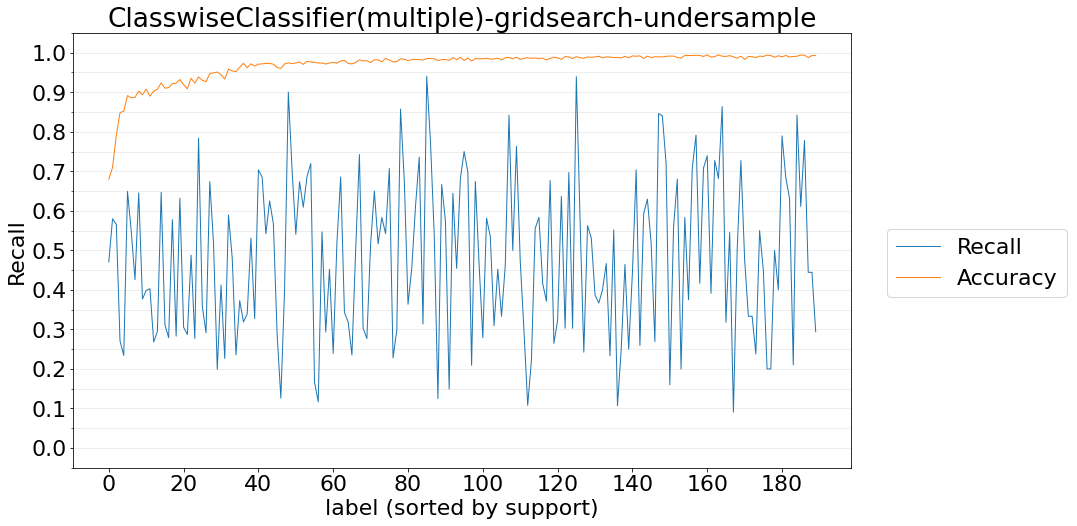

In [9]:
x_ = np.arange(0, len(y_test[0]))
container, fig = plt.subplots(figsize=(16,8))
fig.set_title(name)
sorted_results = sorted(classwise_report, key=lambda x: classwise_report[x]['support'], reverse=True)
fig.plot(x_, [classwise_report[result]['recall'] for result in sorted_results][0:len(x_)], label='Recall')
fig.plot(x_, [classwise_report[result]['accuracy'] for result in sorted_results][0:len(x_)], label="Accuracy")
fig.set_xlabel('label (sorted by support)')
fig.set_ylabel('Recall')
fig.xaxis.set_major_locator(MultipleLocator(20))
fig.yaxis.set_major_locator(MultipleLocator(0.1))
fig.yaxis.set_minor_locator(MultipleLocator(0.05))
fig.set_ylim(-0.05, 1.05)
container.legend(loc='right')
plt.subplots_adjust(right=0.8)
plt.show()